# Objective - Model different scenarios for schools and observe predicted changed in student scores. 

- load model
- retrain model/ validate model accuracy  
- select schools to model 
- generate alternative key feature values to model 
- observe adjusted score predictions 

In [1]:

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

## Load Random Forest Model

In [2]:
expected_model_version = '1.0'
model_path = '../../models/11th_grade_scoring_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

In [3]:
model.version

'1.0'

In [12]:
df = pd.read_csv('../../data/model/XY_final.csv')
df.drop('Unnamed: 0',inplace=True,axis=1)
labels = df[['County_Name', 'District_Name', 'School_Name']].copy()
df.shape

(52665, 63)

In [13]:
X = df[model.X_columns]
print(X.shape)
y = df['Mean Scale Score']
print(y.shape)

(52665, 59)
(52665,)


# Train on all data 

In [14]:
model.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=77))])

In [394]:
# from sklearn import metrics
# metrics.SCORERS.keys()

# Check scores of model 

In [250]:
## on full data set trained predictions 

from sklearn.metrics import mean_absolute_error
y_pred =model.predict(X)
mean_absolute_error(y_pred,y)

4.747067141576639

In [253]:
## cross validated scores

results = cross_validate(model, X, y , 
            scoring=('r2','explained_variance', 'neg_mean_absolute_error'),cv=5)
results
np.mean(-1* results['test_neg_mean_absolute_error']), np.std(results['test_neg_mean_absolute_error'])

(38.24980570913535, 4.386761348222095)

# Can I use the MAE of 4 as I am training on the whole data set for the modeling? or do I need to use the cross_val mae which is 35

## all of my predicted changes in scores are below the mae so I believe this means I can not say they are anything more than random variation instead of clear quality predictions. 

## my mae of the modele pickeled in the training notebook is 13 for the test set, so I am unclear why it would now be 35.

In [251]:


results = cross_validate(model, X, y , cv=5)
scores = results['test_score']
np.mean(scores)

0.563575487256897

# Confirm feature importance 

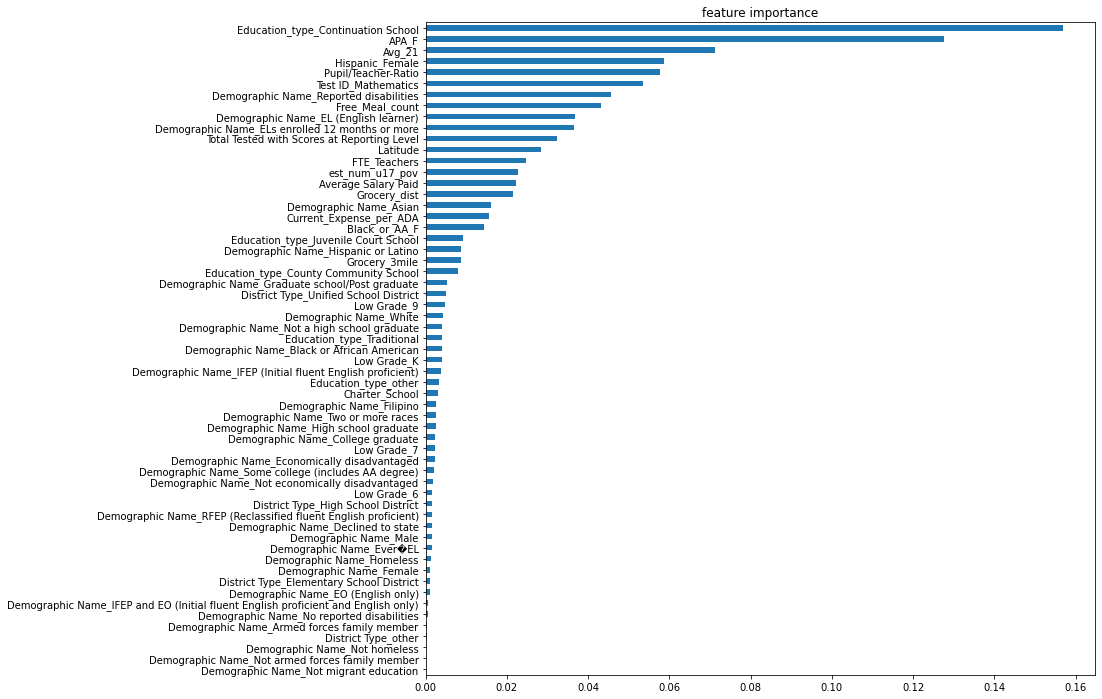

In [9]:
names = zip(model.X_columns,model.named_steps.randomforestregressor.feature_importances_)
names
fig, ax = plt.subplots(figsize=(12,12))
imps = model.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=model.X_columns).sort_values()
plt.title('feature importance')
fig = rf_feat_imps.plot(kind='barh')
plt.show()

#  Function to predict score change 

In [347]:
def predict_change( model,df,school,demographic,features, deltas):
    """Isolate row of df and predict change in scores due to feature change"""
    school=df[df['School_Name'].str.startswith(school)]
    group = 'Demographic Name_'+demographic
    row = school[school[group]==1]


    row = row.drop(['Mean Scale Score', 'County_Name','District_Name', 'School_Name'],axis=1)
    row = row.iloc[0].copy()
    adj_school = row.copy()
    adj_school = pd.DataFrame(adj_school)
    
    for f,d in zip(features, deltas):
        adj_school.loc[f] += d
    return (model.predict(adj_school.values.reshape(1, -1)).item() - model.predict(row.values.reshape(1,-1)).item())


In [343]:
# model.X_columns

## Predict Score changes due to increase in salary 

In [390]:
sal_change= [i for i in range(0,40000,2000)]

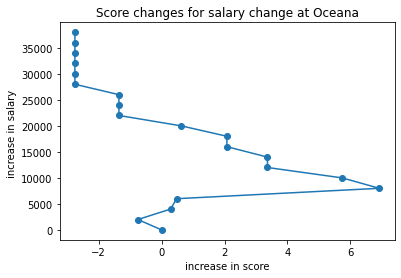

In [391]:


score_deltas = [predict_change(model,df,
                            'Oceana','Filipino',
                            ['Average Salary Paid'],[delta]) for delta in sal_change]
score_deltas
plt.plot(score_deltas,sal_change, 'o-')
plt.title('Score changes for salary change at Oceana')
plt.xlabel('increase in score')
plt.ylabel('increase in salary ')
# plt.gca().invert_xaxis()
plt.show()

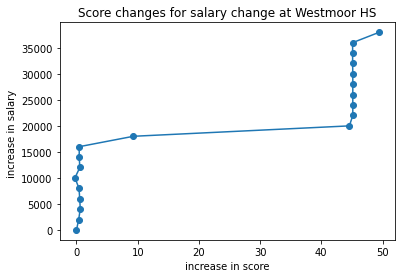

In [392]:


score_deltas = [predict_change(model,df,
                            'Westmoor','Filipino',
                            ['Average Salary Paid'],[delta]) for delta in sal_change]
score_deltas
plt.plot(score_deltas,sal_change, 'o-')
plt.title('Score changes for salary change at Westmoor HS')
plt.xlabel('increase in score')
plt.ylabel('increase in salary ')
# plt.gca().invert_xaxis()
plt.show()

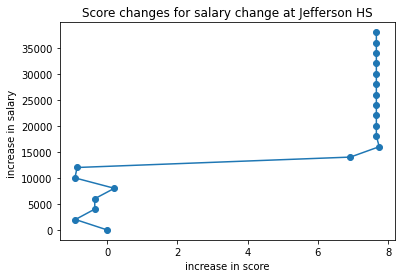

In [393]:


score_deltas = [predict_change(model,df,
                            'Jefferson High','Filipino',
                            ['Average Salary Paid'],[delta]) for delta in sal_change]
score_deltas
plt.plot(score_deltas,sal_change, 'o-')
plt.title('Score changes for salary change at Jefferson HS')
plt.xlabel('increase in score')
plt.ylabel('increase in salary ')
# plt.gca().invert_xaxis()
plt.show()

# Change in full time teachers on scores modeling 

In [380]:
teachers = [i for i in range(0,24,4)]
teachers

[0, 4, 8, 12, 16, 20]

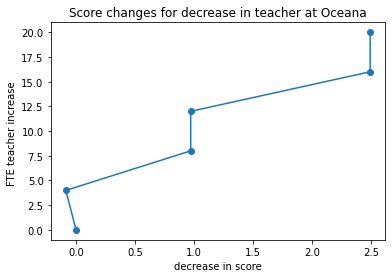

In [381]:

score_deltas = [predict_change(model,df,
                            'Oceana','Filipino',
                            ['FTE_Teachers'],[delta]) for delta in teachers]
score_deltas
plt.plot(score_deltas,teachers, 'o-')
plt.title('Score changes for decrease in teacher at Oceana')
plt.xlabel('decrease in score')
plt.ylabel('FTE teacher increase ')
# plt.gca().invert_xaxis()
plt.show()

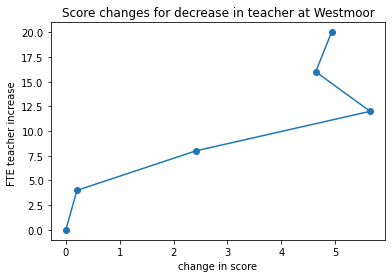

In [383]:

score_deltas = [predict_change(model,df,
                            'Westmoor','Filipino',
                            ['FTE_Teachers'],[delta]) for delta in teachers]
score_deltas
plt.plot(score_deltas,teachers, 'o-')
plt.title('Score changes for decrease in teacher at Westmoor')
plt.xlabel('change in score')
plt.ylabel('FTE teacher increase ')
# plt.gca().invert_xaxis()
plt.show()

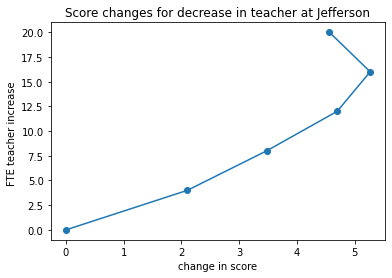

In [385]:

score_deltas = [predict_change(model,df,
                            'Jefferson','Filipino',
                            ['FTE_Teachers'],[delta]) for delta in teachers]
score_deltas
plt.plot(score_deltas,teachers, 'o-')
plt.title('Score changes for decrease in teacher at Jefferson')
plt.xlabel('change in score')
plt.ylabel('FTE teacher increase ')
# plt.gca().invert_xaxis()
plt.show()

# Comparing effect of chaning housing price on schools in Jefferson unified High school district 

In [ ]:
housing_delta = [i for i in range(10000,1000000,100000)]

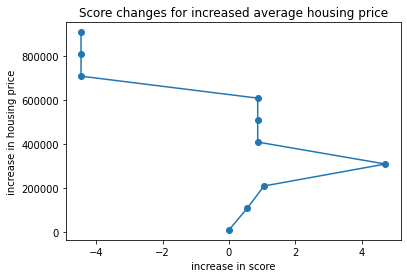

In [350]:

score_deltas = [predict_change(model,df,
                            'Jefferson High','Filipino',
                            ['Avg_21'],[delta]) for delta in housing_delta]


plt.plot(score_deltas,housing_delta, 'o-')
plt.title('Score changes for increased average housing price')
plt.xlabel('increase in score')
plt.ylabel('increase in housing price')
plt.show()

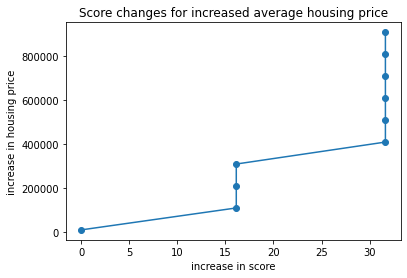

In [351]:

score_deltas = [predict_change(model,df,
                            'Westmoor High','Filipino',
                            ['Avg_21'],[delta]) for delta in housing_delta]
plt.plot(score_deltas,housing_delta, 'o-')
plt.title('Score changes for increased average housing price')
plt.xlabel('increase in score')
plt.ylabel('increase in housing price')
plt.show()

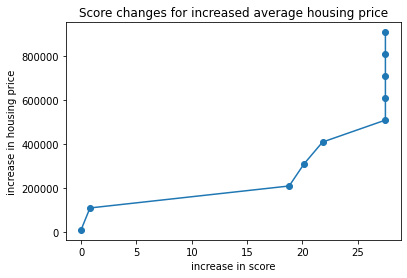

In [368]:


score_deltas = [predict_change(model,df,
                            'Oceana','Filipino',
                            ['Avg_21'],[delta]) for delta in housing_delta]
plt.plot(score_deltas,housing_delta, 'o-')
plt.title('Score changes for increased average housing price')
plt.xlabel('increase in score')
plt.ylabel('increase in housing price')
plt.show()

# Modeling effect of decrease in housing price 

In [290]:
housing_neg = [i for i in range(-10000,-1000000,-100000)]


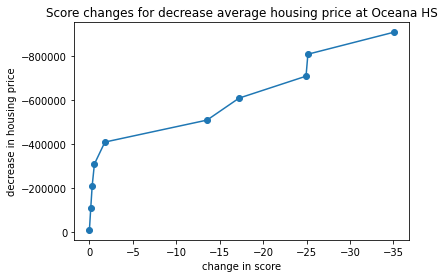

In [369]:
# negative 
score_deltas = [predict_change(model,df,
                            'Oceana','Filipino',
                            ['Avg_21'],[delta]) for delta in housing_neg]
plt.plot(score_deltas,housing_neg, 'o-')
plt.title('Score changes for decrease average housing price at Oceana HS')
plt.xlabel('change in score')
plt.ylabel('decrease in housing price')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()

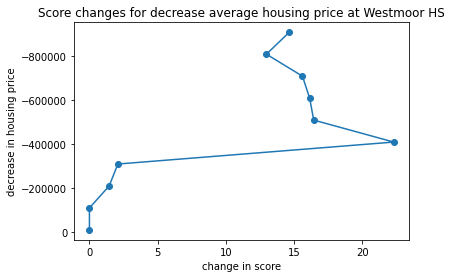

In [354]:
# negative 
score_deltas = [predict_change(model,df,
                            'Westmoor High','Filipino',
                            ['Avg_21'],[delta]) for delta in housing_neg]
plt.plot(score_deltas,housing_neg, 'o-')
plt.title('Score changes for decrease average housing price at Westmoor HS')
plt.xlabel('change in score')
plt.ylabel('decrease in housing price')
plt.gca().invert_yaxis()
plt.show()

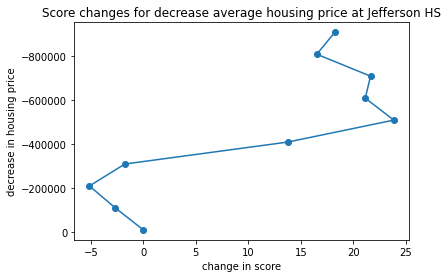

In [353]:
# negative 
score_deltas = [predict_change(model,df,
                            'Jefferson High','Filipino',
                            ['Avg_21'],[delta]) for delta in housing_neg]
plt.plot(score_deltas,housing_neg, 'o-')
plt.title('Score changes for decrease average housing price at Jefferson HS')
plt.xlabel('change in score')
plt.ylabel('decrease in housing price')
# plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [267]:
change = predict_change(model,df,'Oceana','Filipino',['Avg_21','FTE_Teachers'],[-410000,-10])
change

-3.95064935065011

In [54]:
df[df['District_Name'].str.startswith('Jef')]['District_Name'].unique()

array(['Jefferson Union High'], dtype=object)

In [58]:
df[df['County_Name'].str.startswith('San Mateo')]['School_Name'].unique()

array(['Oxford Day Academy', 'California Virtual Academy San Mateo',
       'Jefferson High', 'Oceana High', 'Terra Nova High',
       'Westmoor High', 'Baden High (Continuation)', 'El Camino High',
       'South San Francisco High'], dtype=object)

In [125]:
df[(df['District_Name'].str.startswith('Jef'))
   &(df['Demographic Name_Filipino']==1)]['School_Name'].value_counts()

Westmoor High     6
Jefferson High    6
Oceana High       1
Name: School_Name, dtype: int64

In [61]:
# df['District_Name'].unique()

In [97]:
oceana = df[df['School_Name'].str.startswith('Oceana')]
oceana

,Total Tested with Scores at Reporting Level,Charter_School,Free_Meal_count,Latitude,FTE_Teachers,Pupil/Teacher-Ratio,Hispanic_Female,Black_or_AA_F,APA_F,Avg_21,...,District Type_other,Education_type_Continuation School,Education_type_County Community School,Education_type_Juvenile Court School,Education_type_Traditional,Education_type_other,Mean Scale Score,County_Name,District_Name,School_Name
42665,50.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2671.3,San Mateo,Jefferson Union High,Oceana High
42666,29.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2691.4,San Mateo,Jefferson Union High,Oceana High
42667,21.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2643.6,San Mateo,Jefferson Union High,Oceana High
42668,46.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2687.4,San Mateo,Jefferson Union High,Oceana High
42669,50.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2671.3,San Mateo,Jefferson Union High,Oceana High
42670,11.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2663.3,San Mateo,Jefferson Union High,Oceana High
42671,50.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2671.3,San Mateo,Jefferson Union High,Oceana High
42672,50.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2671.3,San Mateo,Jefferson Union High,Oceana High
42673,11.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2625.6,San Mateo,Jefferson Union High,Oceana High
42674,11.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2713.0,San Mateo,Jefferson Union High,Oceana High


In [110]:
oceana[oceana['Demographic Name_Filipino']==1].loc[:,'Total Tested with Scores at Reporting Level':'Mean Scale Score'].T

,42673
Total Tested with Scores at Reporting Level,1.100000e+01
Charter_School,0.000000e+00
Free_Meal_count,1.130000e+02
Latitude,3.763870e+01
FTE_Teachers,3.165000e+01
Pupil/Teacher-Ratio,1.883000e+01
Hispanic_Female,7.100000e+01
Black_or_AA_F,1.000000e+00
APA_F,9.800000e+01
Avg_21,1.274587e+06
